# Quantitative Momentum Strategy

"Momentum investing" means investing in the stocks that have increased in price the most.

For this project, we're going to build an investing strategy that selects the 50 stocks with the highest price momentum. From there, we will calculate recommended trades for an equal-weight portfolio of these 50 stocks.


## Library Imports

The first thing we need to do is import the open-source software libraries that we'll be using in this tutorial.

In [76]:
pip install xlsxwriter

In [77]:
import numpy as np
import pandas as pd
import requests
import math
from scipy import stats
import xlsxwriter

## Importing Our List of Stocks

As before, we'll need to import our list of stocks and our API token before proceeding. Make sure the `.csv` file is still in your working directory and import it with the following command:

In [78]:
stocks = pd.read_csv('/content/sp500.csv')
stocks

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [79]:
from google.colab import userdata
API_TOKEN = userdata.get('API_TOKEN')

## Making Our First API Call

It's now time to make the first version of our momentum screener!

We need to get one-year price returns for each stock in the universe. Here's how.

In [80]:
symbol = 'AAPL'
api_url = f'https://cloud.iexapis.com/stable/stock/{symbol}/stats?token={API_TOKEN}'
data = requests.get(api_url).json()
data

{'companyName': 'Apple Inc',
 'marketcap': 2909182037040,
 'week52high': 198.57,
 'week52low': 163.63,
 'week52highSplitAdjustOnly': 199.62,
 'week52lowSplitAdjustOnly': 164.08,
 'week52change': 0.11031453644719248,
 'sharesOutstanding': 15334082000,
 'float': 0,
 'avg10Volume': 59563392,
 'avg30Volume': 63853142,
 'day200MovingAvg': 181.5,
 'day50MovingAvg': 173.31,
 'employees': 164000,
 'ttmEPS': 6.43,
 'ttmDividendRate': 0.966204324874062,
 'dividendYield': 0.005092791086201043,
 'nextDividendDate': '',
 'exDividendDate': '2024-05-10',
 'nextEarningsDate': '2024-08-01',
 'peRatio': 28.979091703672715,
 'beta': 1.05132076794146,
 'maxChangePercent': 73.54616895874264,
 'year5ChangePercent': 3.145707230732251,
 'year2ChangePercent': 0.3128176171654433,
 'year1ChangePercent': 0.11431476279109654,
 'ytdChangePercent': -0.00939797900896988,
 'month6ChangePercent': 0.01441743181074484,
 'month3ChangePercent': 0.034672321042918286,
 'month1ChangePercent': 0.10159758359239723,
 'day30Chang

## Parsing Our API Call

This API call has all the information we need. We can parse it using the same square-bracket notation as in the first project of this course. Here is an example.

In [81]:
data['year1ChangePercent']

0.11431476279109654

## Executing A Batch API Call & Building Our DataFrame

Just like in our first project, it's now time to execute several batch API calls and add the information we need to our DataFrame.

We'll start by running the following code cell, which contains some code we already built last time that we can re-use for this project. More specifically, it contains a function called `chunks` that we can use to divide our list of securities into groups of 100.

In [82]:
# Function sourced from
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

symbol_groups = list(chunks(stocks['Symbol'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
#     print(symbol_strings[i])

my_columns = ['Ticker', 'Price', 'One-Year Price Return']

Now we need to create a blank DataFrame and add our data to the data frame one-by-one.

In [83]:
final_dataframe = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_dataframe = final_dataframe._append(
                                        pd.Series([symbol,
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['stats']['year1ChangePercent']
                                                   ],
                                                  index = my_columns),
                                        ignore_index = True)


final_dataframe

,Ticker,Price,One-Year Price Return
0,MMM,105.070,0.071923
1,AOS,85.895,0.293571
2,ABT,104.795,-0.028491
3,ABBV,164.220,0.162688
4,ACN,308.540,0.128852
...,...,...,...
498,XYL,143.145,0.391778
499,YUM,141.330,0.023366
500,ZBRA,321.880,0.196417
501,ZBH,121.070,-0.108936


## Removing Low-Momentum Stocks

The investment strategy that we're building seeks to identify the 50 highest-momentum stocks in the S&P 500.

Because of this, the next thing we need to do is remove all the stocks in our DataFrame that fall below this momentum threshold. We'll sort the DataFrame by the stocks' one-year price return, and drop all stocks outside the top 50.


In [84]:
final_dataframe.sort_values('One-Year Price Return', ascending = False, inplace = True)
final_dataframe = final_dataframe[:50]
final_dataframe.reset_index(inplace = True)
final_dataframe

,index,Ticker,Price,One-Year Price Return
0,429,SMCI,921.630,5.909170
1,476,VST,94.140,3.000363
2,349,NVDA,949.690,2.269602
3,126,CEG,218.090,1.820906
4,347,NRG,84.330,1.582860
5,44,ANET,322.810,1.362879
6,75,AVGO,1420.835,1.321727
7,463,URI,683.955,1.138270
8,491,WDC,74.380,1.059592
9,211,GE,162.260,1.020830


## Calculating the Number of Shares to Buy

Just like in the last project, we now need to calculate the number of shares we need to buy. The one change we're going to make is wrapping this functionality inside a function, since we'll be using it again later in this Jupyter Notebook.

Since we've already done most of the work on this, try to complete the following two code cells without watching me do it first!

In [85]:
def portfolio_input():
  global portfolio_size
  portfolio_size = input('Enter the size of your portfolio:')

  try:
    float(portfolio_size)
  except:
    print('This is not a number! \nPlease try again')
    portfolio_size = input('Enter the size of your portfolio:')


portfolio_input()
portfolio_size

Enter the size of your portfolio:100000


'100000'

In [86]:
position_size = float(portfolio_size) / len(final_dataframe.index)
for i in range(0, len(final_dataframe['Ticker'])-1):
    final_dataframe.loc[i, 'Number Of Shares to Buy'] = math.floor(position_size / final_dataframe['Price'][i])
final_dataframe

<ipython-input-86-06b52d413985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataframe.loc[i, 'Number Of Shares to Buy'] = math.floor(position_size / final_dataframe['Price'][i])


,index,Ticker,Price,One-Year Price Return,Number Of Shares to Buy
0,429,SMCI,921.630,5.909170,2.0
1,476,VST,94.140,3.000363,21.0
2,349,NVDA,949.690,2.269602,2.0
3,126,CEG,218.090,1.820906,9.0
4,347,NRG,84.330,1.582860,23.0
5,44,ANET,322.810,1.362879,6.0
6,75,AVGO,1420.835,1.321727,1.0
7,463,URI,683.955,1.138270,2.0
8,491,WDC,74.380,1.059592,26.0
9,211,GE,162.260,1.020830,12.0


## Building a Better (and More Realistic) Momentum Strategy

Real-world quantitative investment firms differentiate between "high quality" and "low quality" momentum stocks:

* High-quality momentum stocks show "slow and steady" outperformance over long periods of time
* Low-quality momentum stocks might not show any momentum for a long time, and then surge upwards.

The reason why high-quality momentum stocks are preferred is because low-quality momentum can often be cause by short-term news that is unlikely to be repeated in the future (such as an FDA approval for a biotechnology company).

To identify high-quality momentum, we're going to build a strategy that selects stocks from the highest percentiles of:

* 1-month price returns
* 3-month price returns
* 6-month price returns
* 1-year price returns

Let's start by building our DataFrame. You'll notice that I use the abbreviation `hqm` often. It stands for `high-quality momentum`.

In [87]:
hqm_columns = [
                'Ticker',
                'Price',
                'Number of Shares to Buy',
                'One-Year Price Return',
                'One-Year Return Percentile',
                'Six-Month Price Return',
                'Six-Month Return Percentile',
                'Three-Month Price Return',
                'Three-Month Return Percentile',
                'One-Month Price Return',
                'One-Month Return Percentile',
                'HQM Score'
                ]

hqm_dataframe = pd.DataFrame(columns = hqm_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=stats,quote&symbols={symbol_string}&token={API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        hqm_dataframe = hqm_dataframe._append(
                                        pd.Series([symbol,
                                                   data[symbol]['quote']['latestPrice'],
                                                   'N/A',
                                                   data[symbol]['stats']['year1ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month6ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month3ChangePercent'],
                                                   'N/A',
                                                   data[symbol]['stats']['month1ChangePercent'],
                                                   'N/A',
                                                   'N/A'
                                                   ],
                                                  index = hqm_columns),
                                        ignore_index = True)

hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,MMM,105.070,N/A,0.071923,N/A,0.079748,N/A,0.095908,N/A,0.108872,N/A,N/A
1,AOS,85.895,N/A,0.293571,N/A,0.165969,N/A,0.075370,N/A,0.022960,N/A,N/A
2,ABT,104.795,N/A,-0.028491,N/A,0.077720,N/A,-0.075073,N/A,-0.039489,N/A,N/A
3,ABBV,164.225,N/A,0.162688,N/A,0.212930,N/A,-0.063822,N/A,0.013113,N/A,N/A
4,ACN,308.540,N/A,0.128852,N/A,-0.045021,N/A,-0.166336,N/A,-0.015163,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.145,N/A,0.391778,N/A,0.443350,N/A,0.159053,N/A,0.129625,N/A,N/A
499,YUM,141.350,N/A,0.023366,N/A,0.103221,N/A,0.026826,N/A,0.004867,N/A,N/A
500,ZBRA,322.055,N/A,0.196417,N/A,0.492764,N/A,0.141392,N/A,0.144417,N/A,N/A
501,ZBH,121.090,N/A,-0.108936,N/A,0.099089,N/A,-0.025663,N/A,-0.024355,N/A,N/A


## Calculating Momentum Percentiles

We now need to calculate momentum percentile scores for every stock in the universe. More specifically, we need to calculate percentile scores for the following metrics for every stock:

* `One-Year Price Return`
* `Six-Month Price Return`
* `Three-Month Price Return`
* `One-Month Price Return`

Here's how we'll do this:

In [88]:


time_periods = [
                'One-Year',
                'Six-Month',
                'Three-Month',
                'One-Month'
                ]

for row in hqm_dataframe.index:
    for time_period in time_periods:
        hqm_dataframe.loc[row, f'{time_period} Return Percentile'] = stats.percentileofscore(hqm_dataframe[f'{time_period} Price Return'], hqm_dataframe.loc[row, f'{time_period} Price Return'])/100

# for time_period in time_periods:
#     print(hqm_dataframe[f'{time_period} Return Percentile'])

hqm_dataframe



,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,MMM,105.070,N/A,0.071923,0.302187,0.079748,0.296223,0.095908,0.640159,0.108872,0.819085,N/A
1,AOS,85.895,N/A,0.293571,0.650099,0.165969,0.518887,0.075370,0.570577,0.022960,0.377734,N/A
2,ABT,104.795,N/A,-0.028491,0.184891,0.077720,0.290258,-0.075073,0.139165,-0.039489,0.137177,N/A
3,ABBV,164.225,N/A,0.162688,0.469185,0.212930,0.628231,-0.063822,0.163022,0.013113,0.341948,N/A
4,ACN,308.540,N/A,0.128852,0.421471,-0.045021,0.089463,-0.166336,0.045726,-0.015163,0.214712,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.145,N/A,0.391778,0.737575,0.443350,0.926441,0.159053,0.840954,0.129625,0.882704,N/A
499,YUM,141.350,N/A,0.023366,0.238569,0.103221,0.367793,0.026826,0.411531,0.004867,0.27833,N/A
500,ZBRA,322.055,N/A,0.196417,0.530815,0.492764,0.956262,0.141392,0.791252,0.144417,0.908549,N/A
501,ZBH,121.090,N/A,-0.108936,0.11332,0.099089,0.357853,-0.025663,0.258449,-0.024355,0.184891,N/A


## Calculating the HQM Score

We'll now calculate our `HQM Score`, which is the high-quality momentum score that we'll use to filter for stocks in this investing strategy.

The `HQM Score` will be the arithmetic mean of the 4 momentum percentile scores that we calculated in the last section.

To calculate arithmetic mean, we will use the `mean` function from Python's built-in `statistics` module.

In [89]:
from statistics import mean

for row in hqm_dataframe.index:
    momentum_percentiles = []
    for time_period in time_periods:
        momentum_percentiles.append(hqm_dataframe.loc[row, f'{time_period} Return Percentile'])
    hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)

hqm_dataframe

,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,MMM,105.070,N/A,0.071923,0.302187,0.079748,0.296223,0.095908,0.640159,0.108872,0.819085,0.514414
1,AOS,85.895,N/A,0.293571,0.650099,0.165969,0.518887,0.075370,0.570577,0.022960,0.377734,0.529324
2,ABT,104.795,N/A,-0.028491,0.184891,0.077720,0.290258,-0.075073,0.139165,-0.039489,0.137177,0.187873
3,ABBV,164.225,N/A,0.162688,0.469185,0.212930,0.628231,-0.063822,0.163022,0.013113,0.341948,0.400596
4,ACN,308.540,N/A,0.128852,0.421471,-0.045021,0.089463,-0.166336,0.045726,-0.015163,0.214712,0.192843
...,...,...,...,...,...,...,...,...,...,...,...,...
498,XYL,143.145,N/A,0.391778,0.737575,0.443350,0.926441,0.159053,0.840954,0.129625,0.882704,0.846918
499,YUM,141.350,N/A,0.023366,0.238569,0.103221,0.367793,0.026826,0.411531,0.004867,0.27833,0.324056
500,ZBRA,322.055,N/A,0.196417,0.530815,0.492764,0.956262,0.141392,0.791252,0.144417,0.908549,0.79672
501,ZBH,121.090,N/A,-0.108936,0.11332,0.099089,0.357853,-0.025663,0.258449,-0.024355,0.184891,0.228628


## Selecting the 50 Best Momentum Stocks

As before, we can identify the 50 best momentum stocks in our universe by sorting the DataFrame on the `HQM Score` column and dropping all but the top 50 entries.

In [90]:
# hqm_dataframe.sort_values('HQM Score', ascending = False, inplace = True)
# hqm_dataframe = hqm_dataframe[:50]
# hqm_dataframe
hqm_dataframe.sort_values(by = 'HQM Score', ascending = False, inplace = True)
hqm_dataframe = hqm_dataframe[:50]
hqm_dataframe.reset_index(inplace = True)
hqm_dataframe

,index,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,476,VST,94.210,N/A,3.000363,0.998012,1.818339,0.998012,1.142424,1.0,0.420551,0.998012,0.998509
1,126,CEG,218.060,N/A,1.820906,0.994036,0.846276,0.994036,0.704844,0.998012,0.204477,0.970179,0.989066
2,347,NRG,84.330,N/A,1.582860,0.992048,0.801808,0.992048,0.633184,0.996024,0.164608,0.940358,0.980119
3,239,HWM,82.950,N/A,0.864495,0.964215,0.607583,0.980119,0.308691,0.978131,0.304156,0.992048,0.978628
4,44,ANET,322.530,N/A,1.362879,0.99006,0.525358,0.972167,0.223377,0.934394,0.238716,0.982107,0.969682
5,390,QCOM,194.220,N/A,0.926460,0.972167,0.544372,0.976143,0.260368,0.954274,0.145843,0.912525,0.953777
6,209,GRMN,170.460,N/A,0.683462,0.922465,0.450565,0.932406,0.382651,0.986083,0.204109,0.968191,0.952286
7,34,APH,132.320,N/A,0.758475,0.942346,0.488317,0.954274,0.251312,0.952286,0.174126,0.94831,0.949304
8,480,WAB,167.420,N/A,0.729430,0.930417,0.473179,0.944334,0.263353,0.95825,0.163522,0.93837,0.942843
9,288,LDOS,147.490,N/A,0.907626,0.968191,0.411961,0.912525,0.208677,0.920477,0.179132,0.952286,0.93837


## Calculating the Number of Shares to Buy

We'll use the `portfolio_input` function that we created earlier to accept our portfolio size. Then we will use similar logic in a `for` loop to calculate the number of shares to buy for each stock in our investment universe.

In [91]:
portfolio_input()

Enter the size of your portfolio:100000


In [92]:
position_size = float(portfolio_size) / len(hqm_dataframe.index)
for i in range(0, len(hqm_dataframe['Ticker'])-1):
    hqm_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / hqm_dataframe['Price'][i])
hqm_dataframe

,index,Ticker,Price,Number of Shares to Buy,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
0,476,VST,94.210,21,3.000363,0.998012,1.818339,0.998012,1.142424,1.0,0.420551,0.998012,0.998509
1,126,CEG,218.060,9,1.820906,0.994036,0.846276,0.994036,0.704844,0.998012,0.204477,0.970179,0.989066
2,347,NRG,84.330,23,1.582860,0.992048,0.801808,0.992048,0.633184,0.996024,0.164608,0.940358,0.980119
3,239,HWM,82.950,24,0.864495,0.964215,0.607583,0.980119,0.308691,0.978131,0.304156,0.992048,0.978628
4,44,ANET,322.530,6,1.362879,0.99006,0.525358,0.972167,0.223377,0.934394,0.238716,0.982107,0.969682
5,390,QCOM,194.220,10,0.926460,0.972167,0.544372,0.976143,0.260368,0.954274,0.145843,0.912525,0.953777
6,209,GRMN,170.460,11,0.683462,0.922465,0.450565,0.932406,0.382651,0.986083,0.204109,0.968191,0.952286
7,34,APH,132.320,15,0.758475,0.942346,0.488317,0.954274,0.251312,0.952286,0.174126,0.94831,0.949304
8,480,WAB,167.420,11,0.729430,0.930417,0.473179,0.944334,0.263353,0.95825,0.163522,0.93837,0.942843
9,288,LDOS,147.490,13,0.907626,0.968191,0.411961,0.912525,0.208677,0.920477,0.179132,0.952286,0.93837


## Formatting Our Excel Output

We will be using the XlsxWriter library for Python to create nicely-formatted Excel files.

XlsxWriter is an excellent package and offers tons of customization. However, the tradeoff for this is that the library can seem very complicated to new users. Accordingly, this section will be fairly long because I want to do a good job of explaining how XlsxWriter works.

In [93]:
writer = pd.ExcelWriter('momentum_strategy.xlsx', engine='xlsxwriter')
hqm_dataframe.to_excel(writer, sheet_name='Momentum Strategy', index = False)

## Creating the Formats We'll Need For Our .xlsx File

You'll recall from our first project that formats include colors, fonts, and also symbols like % and $. We'll need four main formats for our Excel document:

* String format for tickers
* \$XX.XX format for stock prices
* \$XX,XXX format for market capitalization
* Integer format for the number of shares to purchase

Since we already built our formats in the last section of this course, I've included them below for you. Run this code cell before proceeding.

In [94]:
background_color = '#ffffff'
font_color = '#000000'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [95]:
column_formats = {
                    'A': ['Ticker', string_template],
                    'B': ['Price', dollar_template],
                    'C': ['Number of Shares to Buy', integer_template],
                    'D': ['One-Year Price Return', percent_template],
                    'E': ['One-Year Return Percentile', percent_template],
                    'F': ['Six-Month Price Return', percent_template],
                    'G': ['Six-Month Return Percentile', percent_template],
                    'H': ['Three-Month Price Return', percent_template],
                    'I': ['Three-Month Return Percentile', percent_template],
                    'J': ['One-Month Price Return', percent_template],
                    'K': ['One-Month Return Percentile', percent_template],
                    'L': ['HQM Score', integer_template]
                    }

for column in column_formats.keys():
    writer.sheets['Momentum Strategy'].set_column(f'{column}:{column}', 20, column_formats[column][1])
    writer.sheets['Momentum Strategy'].write(f'{column}1', column_formats[column][0], string_template)

## Saving Our Excel Output

As before, saving our Excel output is very easy:

In [96]:
writer._save()

In [97]:
from google.colab import files
files.download('momentum_strategy.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Calculate Returns for Various Timeframes

This code calculates the returns for different timeframes (one year, six months, three months, and one month) based on the price return data of stocks in the 'hqm_dataframe'.
It assumes equal weighting for all stocks in the portfolio.

## Explanation of variables:
- one_year_return: Total return over one year period
- six_month_return: Total return over six month period
- three_month_return: Total return over three month period
- one_month_return: Total return over one month period
- position_size: Size of each position in the portfolio
- portfolio_size: Total value of the portfolio

## The returns are calculated using the formula:
```Return = (100 * Position Size * Price Return) / ((100 + Price Return) * Portfolio Size)```
- where Price Return is the price return of each stock.

### Adjust the variables 'position_size' and 'portfolio_size' as per your portfolio setup before running this code.

#### Uncomment the variables at the end of the code to view the calculated returns for each timeframe.


In [98]:
one_year_return = 0
one_month_return = 0
three_month_return = 0
six_month_return = 0
for i in range(0, len(hqm_dataframe['Ticker'])-1):
  one_year_return += 100*position_size*(hqm_dataframe['One-Year Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  six_month_return += 100*position_size*(hqm_dataframe['Six-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  three_month_return += 100*position_size*(hqm_dataframe['Three-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*float(portfolio_size))
  one_month_return += 100*position_size*(hqm_dataframe['One-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*float(portfolio_size))

# one_year_return
# six_month_return
# three_month_return
# one_month_return

# Investment Strategy using 80-20 Principle

#### This code implements an investment strategy based on the 80-20 principle, where 80% of the portfolio size is allocated to the top 20% stocks based on HQM Score, and the remaining 20% of the portfolio size is allocated to the rest of the stocks.

## Explanation of variables:
- one_year_return_unequal_weightage: Total return over one year period with unequal weighting
- six_month_return_unequal_weightage: Total return over six month period with unequal weighting
- three_month_return_unequal_weightage: Total return over three month period with unequal weighting
- one_month_return_unequal_weightage: Total return over one month period with unequal weighting
- portfolio_size: Total value of the portfolio

### The code iterates through the stocks in 'hqm_dataframe' and calculates returns for each timeframe based on the 80-20 principle.
### For the top 20% stocks, 80% of the portfolio size is allocated, and for the remaining 80% of stocks, 20% of the portfolio size is allocated.

## The returns are calculated using the formula:
```Return = (100 * Weight * Portfolio Size * Price Return) / ((100 + Price Return) * Total Weight * Portfolio Size)```
- where Weight is the allocation percentage (80% or 20%) based on the stock's position (top 20% or rest 80%).

## Adjust the variable 'portfolio_size' as per your portfolio setup before running this code.

### Uncomment the variables at the end of the code to view the calculated returns for each timeframe.


In [99]:
#If 80-20 principle is followed for investment

one_year_return_unequal_weightage = 0
six_month_return_unequal_weightage = 0
three_month_return_unequal_weightage = 0
one_month_return_unequal_weightage = 0

for i in range(0, len(hqm_dataframe['Ticker'])-1):
  if(i<10):
    one_year_return_unequal_weightage += 100*8*float(portfolio_size)*(hqm_dataframe['One-Year Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    six_month_return_unequal_weightage += 100*8*float(portfolio_size)*(hqm_dataframe['Six-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    three_month_return_unequal_weightage += 100*8*float(portfolio_size)*(hqm_dataframe['Three-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
    one_month_return_unequal_weightage += 100*8*float(portfolio_size)*(hqm_dataframe['One-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*100*float(portfolio_size))
  else:
    one_year_return_unequal_weightage += 100*5*float(portfolio_size)*(hqm_dataframe['One-Year Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    six_month_return_unequal_weightage += 100*5*float(portfolio_size)*(hqm_dataframe['Six-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    three_month_return_unequal_weightage += 100*5*float(portfolio_size)*(hqm_dataframe['Three-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))
    one_month_return_unequal_weightage += 100*5*float(portfolio_size)*(hqm_dataframe['One-Month Price Return'][i])/((100+hqm_dataframe['One-Year Price Return'][i])*1000*float(portfolio_size))


# one_year_return_unequal_weightage
# six_month_return_unequal_weightage
# three_month_return_unequal_weightage
# one_month_return_unequal_weightage

# Bar Graph: Returns Comparison

 - This code generates a bar graph comparing returns under two investment strategies: Equal Weighting and Unequal Weighting (based on the 80-20 principle).
 - Timeframes include 1 month, 3 months, 6 months, and 1 year.
 - Blue bars represent Equal Weighting, while salmon bars represent Unequal Weighting.
Annotations on top display return values.

Usage: Adjust return values for each strategy and run the code to visualize the comparison.


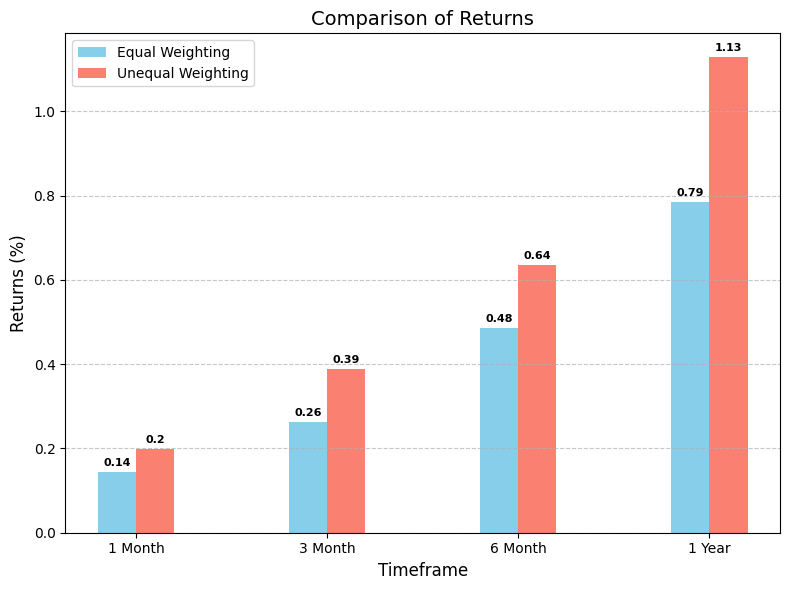

In [101]:
import matplotlib.pyplot as plt
# Define the data
labels = ['1 Month', '3 Month', '6 Month', '1 Year']
returns_equal = [one_month_return, three_month_return, six_month_return, one_year_return]
returns_unequal = [one_month_return_unequal_weightage, three_month_return_unequal_weightage, six_month_return_unequal_weightage, one_year_return_unequal_weightage]

# Create the plot
plt.figure(figsize=(8, 6))
width = 0.2
x = np.arange(len(labels))
rects1 = plt.bar(x - width/2, returns_equal, width, label='Equal Weighting', color='skyblue')
rects2 = plt.bar(x + width/2, returns_unequal, width, label='Unequal Weighting', color='salmon')

# Add labels and title
plt.xlabel("Timeframe", fontsize=12)
plt.ylabel("Returns (%)", fontsize=12)
plt.title('Comparison of Returns', fontsize=14)
plt.xticks(x, labels, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

# Add annotations
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),  # Format the value
                     xy=(rect.get_x() + rect.get_width() / 2, height),  # Center of the bar
                     xytext=(0, 3),  # Offset text slightly above the bar
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8, weight='bold')  # Bold annotation

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
